In [32]:
import random
import numpy as np
from game import Game, Move, Player
from copy import deepcopy
from tqdm import tqdm

border = []
for i in range(5):
    for j in range(5):
        if i == 0 or i == 4 or j == 0 or j == 4:
            border.append((i, j))
BORDER = (list(set(border)))
print(len(BORDER))

ALL_MOVES = []
for pos in BORDER:
    possible_moves = [Move.TOP, Move.BOTTOM, Move.LEFT, Move.RIGHT]
            
    if pos[0] == 0: possible_moves.remove(Move.LEFT)
    if pos[0] == 4: possible_moves.remove(Move.RIGHT)
    if pos[1] == 0: possible_moves.remove(Move.TOP)
    if pos[1] == 4: possible_moves.remove(Move.BOTTOM)

    for move in possible_moves: ALL_MOVES.append((pos, move))
N_ALL = len(ALL_MOVES)

class RandomPlayer(Player):
    def __init__(self) -> None:
        super().__init__()

    def make_move(self, game: 'Game') -> tuple[tuple[int, int], Move]:

        from_pos = random.choice(BORDER)
        while game.get_board()[from_pos[1], from_pos[0]] == 1 - game.current_player_idx: from_pos = random.choice(BORDER)

        possible_moves = [Move.TOP, Move.BOTTOM, Move.LEFT, Move.RIGHT]
            
        if from_pos[0] == 0: possible_moves.remove(Move.LEFT)
        if from_pos[0] == 4: possible_moves.remove(Move.RIGHT)
        if from_pos[1] == 0: possible_moves.remove(Move.TOP)
        if from_pos[1] == 4: possible_moves.remove(Move.BOTTOM)
        
        move = random.choice(possible_moves)

        return from_pos, move

16


In [33]:
class ID_generator:
    def __init__(self):
        self.id = -1
    def get_id(self):
        self.id += 1
        return self.id

In [34]:
def rot(n_rot):
    def rot_n(board): 
        return np.rot90(board, k= n_rot)
    return rot_n

def flip_rot(n_rot):
    def flip_rot_n(board): 
        return np.rot90(np.fliplr(board), k= n_rot)
    return flip_rot_n

rot2 = rot(2)
rot3 = rot(3)
flip_rot1 = flip_rot(1)
flip_rot2 = flip_rot(2)
flip_rot3 = flip_rot(3)

In [35]:
# weight definition
INPUT_SHAPE = (24, 5, 5)
WEIGHT_SHAPE = np.array([
    [
        ('dense', 64),
        ('dense', N_ALL),
    ],
], dtype= object)

def multiply(x):
    res = 1
    for xx in x: res *= xx
    return res

class MyPlayer(Player):
    def __init__(self, id, heritage= None) -> None:
        super().__init__()

        self.id = id

        if heritage is None:
            self.W = []
            self.b = []

            for branch in WEIGHT_SHAPE:
                branch_w = []
                branch_b = []
                in_shape = INPUT_SHAPE

                for layer in branch:
                    #print(in_shape)
                    #print(layer)

                    if layer[0] == 'dense':
                        in_shape = multiply(in_shape)
                        branch_w.append(np.random.random(size= (in_shape, layer[1])))
                        branch_b.append(np.random.random(size= (layer[1],)))
                        in_shape = (layer[1],)

                    elif layer[0] == 'conv':

                        if len(in_shape) == 2:
                            branch_w.append(np.random.random(size= layer[1]))
                            branch_b.append(np.random.random(size= (layer[1][0],)))
                            in_shape = (layer[1][0], in_shape[0] - layer[1][1] + 1, in_shape[1] - layer[1][2] + 1)

                        else:
                            branch_w.append(np.random.random(size= (layer[1][0] * in_shape[0], layer[1][1], layer[1][2])))
                            branch_b.append(np.random.random(size= (layer[1][0] * in_shape[0],)))
                            in_shape = (layer[1][0] * in_shape[0], in_shape[1] - layer[1][1] + 1, in_shape[2] - layer[1][2] + 1)

                    else: print('error')

                    #print(branch_w[-1].shape)
                    #print(branch_b[-1].shape)
                    #print('-')

                    #print(in_shape)
                #print('-----')

                self.W.append(branch_w)
                self.b.append(branch_b)

            self.W = np.array(self.W, dtype= object)
            self.b = np.array(self.b, dtype= object)

        else:
            self.W = heritage[0]
            self.b = heritage[1]

        self.fitness = 0
        self.until_surrend = 100
        self.epoch_before_death = 3

    def get_id(self): return self.id
    def reset_fitness(self) -> None: self.fitness = 0
    def mod_fitness(self, mod) -> None: self.fitness += mod
    def get_fitness(self): return self.fitness
    def set_fitness(self, new_value) -> None: self.fitness = new_value
    def get_weights(self): return self.W
    def get_biases(self): return self.b
    def prepare_to_surrend(self, amount= 100)-> None: self.until_surrend = amount
    def get_death(self, bonus= None):
        if bonus is not None: self.epoch_before_death = bonus + 1
        self.epoch_before_death -= 1
        return self.epoch_before_death
    
    def add_weights(self, branch_shape):
        new_W = [branch_w for branch_w in self.W]
        new_b = [branch_b for branch_b in self.b]
        branch_w = []
        branch_b = []

        in_shape = INPUT_SHAPE

        for layer in branch_shape:

            if layer[0] == 'dense':
                in_shape = multiply(in_shape)
                branch_w.append(np.random.random(size= (in_shape, layer[1])))
                branch_b.append(np.random.random(size= (layer[1],)))
                in_shape = (layer[1],)

            elif layer[0] == 'conv':

                if len(in_shape) == 2:
                    branch_w.append(np.random.random(size= layer[1]))
                    branch_b.append(np.random.random(size= (layer[1][0],)))
                    in_shape = (layer[1][0], in_shape[0] - layer[1][1] + 1, in_shape[1] - layer[1][2] + 1)

                else:
                    branch_w.append(np.random.random(size= (layer[1][0] * in_shape[0], layer[1][1], layer[1][2])))
                    branch_b.append(np.random.random(size= (layer[1][0] * in_shape[0],)))
                    in_shape = (layer[1][0] * in_shape[0], in_shape[1] - layer[1][1] + 1, in_shape[2] - layer[1][2] + 1)

            else: print('error')

        new_W.append(branch_w)
        new_b.append(branch_b)

        self.W = np.array(self.W, dtype= object)
        self.b = np.array(self.b, dtype= object)
    
    def compute_move(self, X):
        branch_outputs = []

        for i_branch in range(len(self.W)):
            layer_input = deepcopy(X)

            for i_layer in range(len(self.W[i_branch])):
                layer_info = WEIGHT_SHAPE[i_branch][i_layer]

                if layer_info[0] == 'dense':
                    layer_output = np.dot(layer_input.flatten(), self.W[i_branch][i_layer]) + self.b[i_branch][i_layer]
                
                elif layer_info[0] == 'conv':

                    if len(layer_input.shape) == 2:
                        layer_output = np.zeros((layer_info[1][0], layer_input.shape[0] - layer_info[1][1] + 1, layer_input.shape[1] - layer_info[1][2] + 1))
                        for k in range(layer_output.shape[0]):
                            for i in range(layer_output.shape[1]):
                                for j in range(layer_output.shape[2]):
                                    layer_output[k, i, j] = sum(sum(layer_input[i:i+layer_info[1][1], j:j+layer_info[1][2]] * self.W[i_branch][i_layer][k]))
                    
                    else:
                        layer_output = np.zeros((layer_info[1][0] * layer_input.shape[0], layer_input.shape[1] - layer_info[1][1] + 1, layer_input.shape[2] - layer_info[1][2] + 1))
                        for k_in in range(layer_input.shape[0]):
                            for k in range(layer_info[1][0]):
                                for i in range(layer_output.shape[1]):
                                    for j in range(layer_output.shape[2]):
                                        layer_output[k_in*layer_info[1][0]+k, i, j] = sum(sum(layer_input[k_in, i:i+layer_info[1][1], j:j+layer_info[1][2]] * self.W[i_branch][i_layer][k_in*layer_info[1][0]+k]))
                
                else: print('error')

                layer_input = layer_output
                #print(f'{(i_branch, i_layer)} -> {layer_output.shape}')
            
            branch_outputs.append(layer_output)

        output = np.sum(branch_outputs, axis= 0)
        output = np.argmax(output)
        
        return output


    def make_move(self, game: 'Game') -> tuple[tuple[int, int], Move]:

        self.until_surrend -= 1
        if self.until_surrend == 0:
            #print('surrendering')
            self.fitness -= 100
            return (-1, -1), None
        
        ## provare a generare tre mappe dalla board, una per ogni [-1, 0, 1] con 1 se [-1, 0, 1] in tile e 0 se altre
        #--------------------------------------

        board = game.get_board()
        X = np.zeros((3, board.shape[0], board.shape[1]))
        X[0][board == -1] = 1
        X[1][board == 0] = 1
        X[2][board == 1] = 1

        ######################################
        
        ## provare a generare una mappa per simmetria
        #--------------------------------------

        X2 = np.zeros((24, board.shape[0], board.shape[1]))
        c = 0
        for x in X:
            X2[c] = x
            c += 1
            for sim in [np.rot90, rot2, rot3, np.fliplr, flip_rot1, flip_rot2, flip_rot3]:
                X2[c] = sim(x)
                c += 1
        X = X2

        ######################################
        
        # invert the board based on player_turn to better recognize enemies from allies
        #--------------------------------------
        
        if game.current_player_idx == 1: pass
        else:
            tmp = deepcopy(X[1])
            X[1] = deepcopy(X[2])
            X[2] = tmp

        #######################################

        # compute move
        #--------------------------------------

        from_pos, move = ALL_MOVES[self.compute_move(X)]

        #######################################

        # random move if illegal move chosen with penalty
        #--------------------------------------

        if game.get_board()[from_pos[1], from_pos[0]] == 1 - game.current_player_idx:

            #print('random used - penalty')
            self.fitness -= 10

            from_pos = random.choice(BORDER)
            while game.get_board()[from_pos[1], from_pos[0]] == 1 - game.current_player_idx: from_pos = random.choice(BORDER)

            possible_moves = [Move.TOP, Move.BOTTOM, Move.LEFT, Move.RIGHT]
                
            if from_pos[0] == 0: possible_moves.remove(Move.LEFT)
            if from_pos[0] == 4: possible_moves.remove(Move.RIGHT)
            if from_pos[1] == 0: possible_moves.remove(Move.TOP)
            if from_pos[1] == 4: possible_moves.remove(Move.BOTTOM)
            
            move = random.choice(possible_moves)

        #######################################
            
        # removing 1 to fitness for each move to force active play
        #--------------------------------------
        
        self.fitness -= 1

        #######################################
        
        return from_pos, move

In [36]:
id_gen = ID_generator()
player = MyPlayer(id_gen.get_id())
game = Game()
player.make_move(game)

((2, 0), <Move.BOTTOM: 1>)

In [37]:
N_TRIALS = 10

## maybe N_TRIALS should depend on N_ALL

def evaluate_population(population, fs= None, avg_player = None):

    for p in tqdm(population):
        
        p.reset_fitness()

        for _ in range(N_TRIALS):

            if fs is None or fs == 'onlyfirst':
                p.prepare_to_surrend()
                p.mod_fitness(((1 - Game().play(p, RandomPlayer())) * 2 - 1) * 100)

            if fs is None or fs == 'onlysecond':
                p.prepare_to_surrend()
                p.mod_fitness((Game().play(RandomPlayer(), p) * 2 - 1) * 100)

    if avg_player is not None: evaluate_population_2(population, avg_player, fs= fs)

def evaluate_population_2(population, avg_player, fs= None):

    freeze_fitness = avg_player.get_fitness()

    for p in population:

        for _ in range(1):

            if fs is None or fs == 'first':
                p.prepare_to_surrend()
                avg_player.prepare_to_surrend()
                winner = Game().play(p, avg_player)
                p.mod_fitness(((1 - winner) * 2 - 1) * 100)

            if fs is None or fs == 'second':
                p.prepare_to_surrend()
                avg_player.prepare_to_surrend()
                winner = Game().play(avg_player, p)
                p.mod_fitness((winner * 2 - 1) * 100)
    
    avg_player.set_fitness(freeze_fitness)
            

In [38]:
def procreate_1(p1, p2, c1, c2, id):
    
    W1 = p1.get_weights()
    b1 = p1.get_biases()
    W2 = p2.get_weights()
    b2 = p2.get_biases()

    W3 = deepcopy(W1)
    b3 = deepcopy(b1)

    c = c1 / (c1 + c2)

    for i in range(len(W1)):
        for j in range(len(W1[i])):
            if c < np.random.random():
                W3[i][j] = W2[i][j]
                b3[i][j] = b2[i][j]

    return MyPlayer(id, heritage= (W3, b3))

def procreate_2(p1, p2, c1, c2, id):
    
    W1 = p1.get_weights()
    b1 = p1.get_biases()
    W2 = p2.get_weights()
    b2 = p2.get_biases()

    W3 = deepcopy(W1)
    b3 = deepcopy(b1)

    c = c1 / (c1 + c2)

    for i in range(len(W1)):
        if c < np.random.random():
            W3[i] = W2[i]
            b3[i] = b2[i]

    return MyPlayer(id, heritage= (W3, b3))

def softmax_temp(x, t= 1):
    e_x = np.exp(x / t)
    return e_x / sum(e_x)

def procreation(population, id_generator):
        
    mod_scores = softmax_temp(np.array([p.get_fitness() for p in population]), 1000)
    
    parents = []
    for _ in range(15):
        parents.append(np.random.choice([i for i in range(len(population))], size= (2,), replace= False, p= mod_scores))

    childrens = []
    for pair in parents:
        pi = population[pair[0]]
        pj = population[pair[1]]
        mod_i = mod_scores[pair[0]]
        mod_j = mod_scores[pair[1]]
        
        rand = np.random.random()
        if 0.5 >= rand:
            childrens.append(procreate_1(pi, pj, mod_i, mod_j, id_generator.get_id()))
        else:
            childrens.append(procreate_2(pi, pj, mod_i, mod_j, id_generator.get_id()))

    return childrens

In [39]:
P_MUTATION = 0.2
MUTATION_STRENGTH = 0.01

def mutate_1(p, id):

    Wm = deepcopy(p.get_weights())
    bm = deepcopy(p.get_biases())

    for i in range(len(Wm)):
        for j in range(len(Wm[i])):

            for ii in range(Wm[i][j].shape[0]):
                for jj in range(Wm[i][j].shape[1]):
                    if P_MUTATION >= np.random.random():
                        Wm[i][j][ii, jj] += np.random.normal(0, MUTATION_STRENGTH, size= Wm[i][j][ii, jj].shape)

            for ii in range(bm[i][j].shape[0]):
                if P_MUTATION >= np.random.random():
                    bm[i][j][ii] += np.random.normal(0, MUTATION_STRENGTH, size= bm[i][j][ii].shape)

    return MyPlayer(id, heritage= (Wm, bm))

def mutate_2(p, id):

    Wm = deepcopy(p.get_weights())
    bm = deepcopy(p.get_biases())

    for i in range(len(Wm)):
        for j in range(len(Wm[i])):
            if P_MUTATION >= np.random.random():
                Wm[i][j] += np.random.normal(0, MUTATION_STRENGTH, size= Wm[i][j].shape)
            if P_MUTATION >= np.random.random():
                bm[i][j] += np.random.normal(0, MUTATION_STRENGTH, size= bm[i][j].shape)

    return MyPlayer(id, heritage= (Wm, bm))

def mutation(population, id_generator):

    bases = np.random.choice([i for i in range(len(population))], size= (15,), replace= False)

    mutants = []
    for base in bases:
        p = population[base]
        rand = np.random.random()
        if 0.5 >= rand:
            mutants.append(mutate_1(p, id_generator.get_id()))
        else:
            mutants.append(mutate_2(p, id_generator.get_id()))

    return mutants

In [40]:
MAX_EPOCH = 10
MAX_POPULATION = 100

id_generator = ID_generator()

population = [MyPlayer(id_generator.get_id()) for _ in range(MAX_POPULATION)]

ids = []
ps = []
tot_scores = []
times = []

for epoch in range(MAX_EPOCH):

    print(f'------------------------------------\nepoch {epoch}')

    evaluate_population(population)
    #evaluate_population(population, avg_player= population[len(population) // 2])
    scores = np.array([p.get_fitness() for p in population])

    idx_sort = np.argsort(scores)[::-1]
    scores = scores[idx_sort]
    population = [population[i] for i in idx_sort]

    print(scores[:10])
    print([p.get_id() for p in population[:10]])

    # compute avg ranking
    #--------------------------------------

    for p, s in zip(population, scores):
        p_id = p.get_id()

        if p_id in ids:
            idx = np.argwhere(np.array(ids) == p_id)[0][0]
            tot_scores[idx] += s
            times[idx] += 1

        else:
            ids.append(p_id)
            ps.append(p)
            tot_scores.append(s)
            times.append(1)

    #######################################

    # provare ad implementare morte dopo tot che non si è tra i primi tot
    #--------------------------------------

    to_death = []
    for i, p in enumerate(population):
        bonus_epochs = 4 if i < MAX_POPULATION / 2 else None
        if p.get_death(bonus_epochs) == 0: to_death.append(p)
    for p in to_death: population.remove(p)

    # provare ad implementare morte dopo tot che non si è tra i primi tot
    #--------------------------------------

    if epoch in [2, 4]:
        for p in population: p.add_weights(
            [
                ('dense', 64),
                ('dense', N_ALL),
            ]
        )

    #######################################

    ## magari aumentare e diminuire aumento popolazione in base a grandezza popolazione

    print(f'before: {len(population)}')

    ## procreazione (probabilita dipendente da fitness)

    childrens = procreation(population, id_generator)
    print(f'n_childrens: {len(childrens)}')

    ## mutazioni (tante ma random su individui random)

    mutants = mutation(population, id_generator)
    print(f'n_mutants: {len(mutants)}')

    for child in childrens: population.append(child)
    for mutant in mutants: population.append(mutant)

    print(f'after: {len(population)}')

    #

------------------------------------
epoch 0


100%|██████████| 100/100 [00:17<00:00,  5.78it/s]


[1859 1610 1479 1457 1442 1408 1383 1378 1260 1159]
[83, 67, 44, 72, 29, 37, 28, 10, 75, 26]
before: 100
n_childrens: 15
n_mutants: 15
after: 130
------------------------------------
epoch 1


100%|██████████| 130/130 [00:20<00:00,  6.41it/s]


[1879 1774 1752 1686 1656 1619 1574 1563 1549 1541]
[67, 107, 37, 10, 11, 110, 72, 112, 101, 103]
before: 130
n_childrens: 15
n_mutants: 15
after: 160
------------------------------------
epoch 2


100%|██████████| 160/160 [00:24<00:00,  6.60it/s]


[1869 1864 1853 1788 1761 1702 1701 1632 1627 1618]
[137, 10, 138, 103, 142, 145, 149, 67, 1, 134]
before: 110
n_childrens: 15
n_mutants: 15
after: 140
------------------------------------
epoch 3


100%|██████████| 140/140 [00:16<00:00,  8.48it/s]


[1875 1760 1701 1675 1666 1609 1595 1572 1567 1563]
[103, 106, 177, 164, 142, 104, 74, 10, 11, 143]
before: 130
n_childrens: 15
n_mutants: 15
after: 160
------------------------------------
epoch 4


100%|██████████| 160/160 [00:17<00:00,  9.08it/s]


[1836 1834 1812 1787 1650 1586 1529 1529 1508 1475]
[110, 76, 164, 123, 104, 135, 83, 74, 198, 183]
before: 130
n_childrens: 15
n_mutants: 15
after: 160
------------------------------------
epoch 5


100%|██████████| 160/160 [00:14<00:00, 10.71it/s]


[1738 1730 1701 1645 1623 1618 1618 1612 1603 1597]
[100, 166, 183, 199, 10, 152, 163, 162, 217, 246]
before: 136
n_childrens: 15
n_mutants: 15
after: 166
------------------------------------
epoch 6


100%|██████████| 166/166 [00:14<00:00, 11.74it/s]


[1878 1871 1824 1801 1800 1789 1750 1749 1745 1739]
[251, 145, 278, 28, 239, 250, 123, 265, 244, 29]
before: 142
n_childrens: 15
n_mutants: 15
after: 172
------------------------------------
epoch 7


100%|██████████| 172/172 [00:14<00:00, 12.00it/s]


[1875 1801 1789 1789 1787 1759 1749 1737 1698 1661]
[258, 256, 305, 100, 202, 297, 83, 161, 186, 302]
before: 144
n_childrens: 15
n_mutants: 15
after: 174
------------------------------------
epoch 8


100%|██████████| 174/174 [00:13<00:00, 12.79it/s]


[1881 1867 1864 1851 1846 1846 1839 1786 1776 1771]
[323, 234, 261, 262, 274, 332, 302, 314, 279, 162]
before: 156
n_childrens: 15
n_mutants: 15
after: 186
------------------------------------
epoch 9


100%|██████████| 186/186 [00:14<00:00, 12.50it/s]


[1840 1794 1768 1764 1750 1706 1697 1694 1683 1682]
[163, 284, 323, 152, 329, 317, 1, 332, 195, 295]
before: 164
n_childrens: 15
n_mutants: 15
after: 194


163
[323, 332, 346, 364, 341, 368, 324, 354, 318, 343]
[2, 2, 1, 1, 1, 1, 2, 1, 2, 1]
[1824.5 1770.  1645.  1626.  1608.  1598.  1564.5 1564.  1558.5 1545. ]


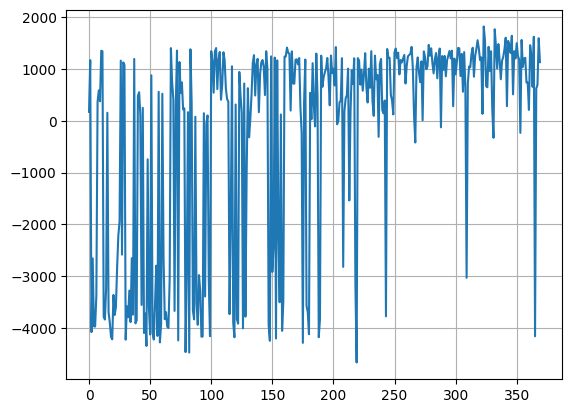

In [41]:
avg_scores = np.array(tot_scores) / np.array(times)

idx_sort = np.argsort(avg_scores)[::-1]

ids = [ids[i] for i in idx_sort]
ps = [ps[i] for i in idx_sort]
tot_scores = [tot_scores[i] for i in idx_sort]
times = [times[i] for i in idx_sort]
avg_scores = avg_scores[idx_sort]

print(population[0].get_id())
print(ids[:10])
print(times[:10])
print(avg_scores[:10])

idx_sort = np.argsort(ids)[::-1]

ids = [ids[i] for i in idx_sort]
ps = [ps[i] for i in idx_sort]
tot_scores = [tot_scores[i] for i in idx_sort]
times = [times[i] for i in idx_sort]
avg_scores = avg_scores[idx_sort]

import matplotlib.pyplot as plt

x = ids
y = avg_scores
plt.plot(x, y)
plt.grid()
plt.show()



In [42]:
#ThePlayer = population[0]
ThePlayer = ps[0]

In [43]:
wins_first = 0
wins_second = 0
n_trials = 1000

player1 = ThePlayer
player2 = RandomPlayer()

for _ in tqdm(range(n_trials)):
    g = Game()

    player1.prepare_to_surrend(500)
    winner = g.play(player1, player2)

    if winner == 0: wins_first += 1

    g = Game()

    player1.prepare_to_surrend(500)
    winner = g.play(player2, player1)

    if winner == 1: wins_second += 1

print(f"Player won {wins_first} / {n_trials} as first")
print(f"Player won {wins_second} / {n_trials} as second")

100%|██████████| 1000/1000 [00:07<00:00, 135.35it/s]

Player won 926 / 1000 as first
Player won 892 / 1000 as second
